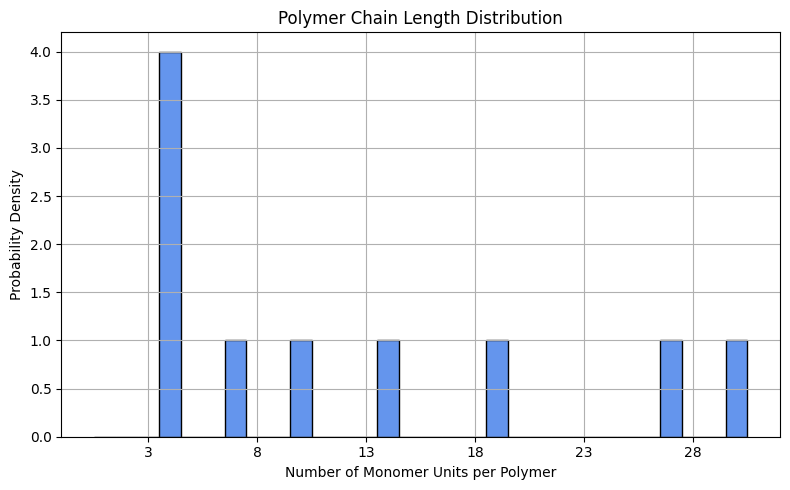

12.3 19.504065040650406 1.5856963447683257


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

def generate_polymer_population(Mn, PDI, N):
    Z = (1 / (PDI - 1)) ** 2
    scale = Mn / Z
    chain_lengths = gamma.rvs(a=Z, scale=scale, size=N)
    chain_lengths = np.round(chain_lengths).astype(int)
    
    # Clip values to stay within 1 to 30 monomer units
    chain_lengths = np.clip(chain_lengths, 4, 30)
    
    return chain_lengths

def plot_distribution(chain_lengths):
    plt.figure(figsize=(8, 5))
    plt.hist(chain_lengths, bins=np.arange(0.5, 31.5, 1), density=False, 
             color='cornflowerblue', edgecolor='black')
    plt.xlabel('Number of Monomer Units per Polymer')
    plt.ylabel('Probability Density')
    plt.title('Polymer Chain Length Distribution')
    plt.grid(True)

    # Set x-ticks from 1 to 30 in steps of 5
    plt.xticks(np.arange(3, 31, 5))

    plt.tight_layout()
    plt.show()


Mn = 10      
PDI = 2.5
N = 10

chain_lengths = generate_polymer_population(Mn, PDI, N)
plot_distribution(chain_lengths)

chain_len = np.array(chain_lengths)

Mn = np.mean(chain_len)
Mw = np.sum(chain_len**2) / np.sum(chain_len)
PDI = Mw / Mn

print(Mn, Mw, PDI)
# Calculate the number of chains of each length
value_counts_dict = dict(zip(*np.unique(chain_lengths, return_counts=True)))



In [6]:
generated_arrays = {}

# Loop through each chain length (key)
for n in value_counts_dict.keys():
    arrays = []
    for _ in range(value_counts_dict[n]):
        arr = np.ones(n, dtype=int)
        if n > 7:
            idx = np.random.randint(0, n)
            arr[idx] = 0
        if n > 11:
            idx = np.random.randint(0, n-1)
            arr[idx] = 0
 
        arrays.append(arr)
    generated_arrays[n] = arrays

In [18]:
#generate chain distributions and topol files

import os
output_dir="Chains_output"
os.makedirs(output_dir, exist_ok=True)
x=0 #set a small counter to tag chains with 3 letter code
import generate_itp
itplist = []
countlist = []  
for length, arr_list in generated_arrays.items():
    n = np.array([])
    count = 0
    for arr in arr_list:
        if np.array_equal(arr, n):
            count += 1
        else:
            
            # Print the count for the previous array before resetting
            if count > 0:
                x=x+1
                code = chr(64 + x)*3
                print("Array:", n)
                print("Occurrences:", count)
                id = "".join(map(str, n)).replace("[", "").replace("]", "").replace("'", "").replace(",", "").replace(" ", "")
                itpfilename = os.path.join(output_dir, f"PEG{length}mer_{id}.itp")
                itplist.append(os.path.join(f"PEG{length}mer_{id}.itp"))
                grofilename = os.path.join(output_dir, f"PEG{length}mer_{id}.gro")

                #generate_itp.generate_itps(itpfilename, grofilename, n, code)
                

            count = 1  # Reset count for the new array
        n = arr
    # Print the last array and its count after the loop
    if count > 0:
        x = x+1
        code = chr(64 + x)*3
        countlist.append(count)  
        print("Array:", n)
        print("Occurrences:", count)
        id = "".join(map(str, n)).replace("[", "").replace("]", "").replace("'", "").replace(",", "").replace(" ", "")
        itpfilename = os.path.join(output_dir, f"PEG{length}mer_{id}.itp")
        itplist.append(os.path.join(f"PEG{length}mer_{id}.itp"))
        grofilename = os.path.join(output_dir, f"PEG{length}mer_{id}.gro")

        #generate_itp.generate_itps(itpfilename,grofilename, n, code)
print(countlist)

Array: [1 1 1 1]
Occurrences: 4
Array: [1 1 1 1 1 1 1]
Occurrences: 1
Array: [1 1 1 1 0 1 1 1 1 1]
Occurrences: 1
Array: [1 1 1 1 1 1 1 1 1 0 1 1 1 1]
Occurrences: 1
Array: [1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
Occurrences: 1
Array: [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
Occurrences: 1
Array: [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Occurrences: 1
[4, 1, 1, 1, 1, 1, 1]


In [ ]:

topolfile = os.path.join(output_dir, "topol.top")
with open (topolfile, 'w+') as file:
    #Title line 
    print(';Polymer topology | developed by ChamikaraK University of Arizona | \n;Explicit Hirshfield charge populations (CM5) and torsional potentials @DFT Optially tuned (0.1533 bohr-1) HPBE 6-31G** \n', file=file)
    print('#include        "ffnb.itp"\n', file=file)
    print('#include        "forcefield.itp"\n', file=file)
    print('[ system ]\nPEG\n[ molecules ]', file=file)
    for n, itpfile in enumerate(itplist, start=1):
        if n <= len(countlist):  # Ensure we don't access out-of-range indices
            print(f'{chr(64 + n)*3}      {countlist[n-1]} ', file=file)
        else:
            print(f'{chr(64 + n)*3}      1 ', file=file)  # Default count to 1 if missing
        
        

fffile = os.path.join(output_dir, "forcefield.itp")
with open (fffile, 'w+') as file:
    print('[ defaults ]\n; nbfunc        comb-rule       gen-pairs       fudgeLJ fudgeQQ\n  1             3               yes             0.5     0.8333\n', file=file)
    for itpfile in itplist:
        n = itplist.index(itpfile) + 1
    for itpfile in itplist:
        print('#include        "{}"'.format(itpfile), file=file)

['PEG4mer_1111.gro',
 'PEG7mer_1111111.gro',
 'PEG10mer_1111011111.gro',
 'PEG14mer_11111111101111.gro',
 'PEG19mer_1110111111011111111.gro',
 'PEG27mer_111111110111111111111110111.gro',
 'PEG30mer_111110111111111011111111111111.gro']

In [ ]:
#create separations 
grolist = [itp.replace("itp", "gro") for itp in itplist]
gro_count_dict = dict(zip(grolist, countlist))
gro_count_dict




In [ ]:
# File paths
input_file = 'Chains_output/PEG4mer_1111.gro'
output_file = 'Chains_output/PEG4mer_1111_modified.gro'

def genstacks(input_file, output_file, increment):
    # Value to add


    # Read original lines
    with open(input_file, 'r') as f:
        lines = f.readlines()

    # Modify the appropriate lines
    updated_lines = []
    for i, line in enumerate(lines):
        if i < 2 or i == len(lines) - 1:
            updated_lines.append(line)
            continue

        # For GRO files, the coordinates typically start at fixed positions
        # Example fixed width: columns at positions 20–28, 28–36, 36–44 for x, y, z
        # Here we modify z-coordinate (assumed to be from 36–44)
        try:
            y_str = line[28:36]
            y_val = float(y_str)
            new_y = f"{y_val + increment:8.3f}"
            new_line = line[:36] + new_y + line[44:]
        except ValueError:
            new_line = line  # leave it untouched if parsing fails

        updated_lines.append(new_line)

    # Write to new file
    with open(output_file, 'w') as f:
        f.writelines(updated_lines)


In [34]:
def print_iterative_items(gro_count_dict):
    counter = 0
    increment = 0.38424
    for key, n in gro_count_dict.items():
        print(f"{key}:")
        for _ in range(n):
            print(counter)
            counter += 1
            inc = increment*counter
            genstacks(f"Chains_output/{key}", f"Chains_output/stack{counter}{key}", inc)
        

In [35]:
print_iterative_items(gro_count_dict)

PEG4mer_1111.gro:
0
1
2
3
PEG7mer_1111111.gro:
4
PEG10mer_1111011111.gro:
5
PEG14mer_11111111101111.gro:
6
PEG19mer_1110111111011111111.gro:
7
PEG27mer_111111110111111111111110111.gro:
8
PEG30mer_111110111111111011111111111111.gro:
9
